# Image analysis with Squidpy
Tutorial by Hannah Spitzer and Giovanni Palla, Spatial Omics Data Analysis 2022.

*TL;DR we show how to segment high-resolution tissues images and extract features from them for joint analysis with ST data*

## Background

Visium datasets contain high-resolution images of the tissue which might contain complementary information to the gene expression data. 
Specifically, we might be interested in extracting intensity, morphology, or texture features from the tissue images and correlate it with gene expression. Tissue images also provide information about previse localisation of cells and therefore allow us to associate cell counts with specific visium spots. 
Here, we'll show how to extract these information from images using [Squidpy](https://doi.org/10.1038/s41592-021-01358-2).

For more information about Squidpy's ImageContainer feature extraction functions, please also check out the [Squidpy tutorials](https://squidpy.readthedocs.io/en/stable/tutorials.html). This tutorial was adapted from [here](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_visium_fluo.html).

## Datasets

The dataset used here consists of a Visium slide of a coronal section of the mouse brain. The dataset was originally released by 10x genomics and was pre-processed in Squidpy.

In [1]:
%pip install scikit-image>0.19

import scanpy as sc
import anndata as ad
import squidpy as sq

import pandas as pd

import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(5, 5))

Note: you may need to restart the kernel to use updated packages.


In [2]:
img = sq.datasets.visium_fluo_image_crop()
adata = sq.datasets.visium_fluo_adata_crop()

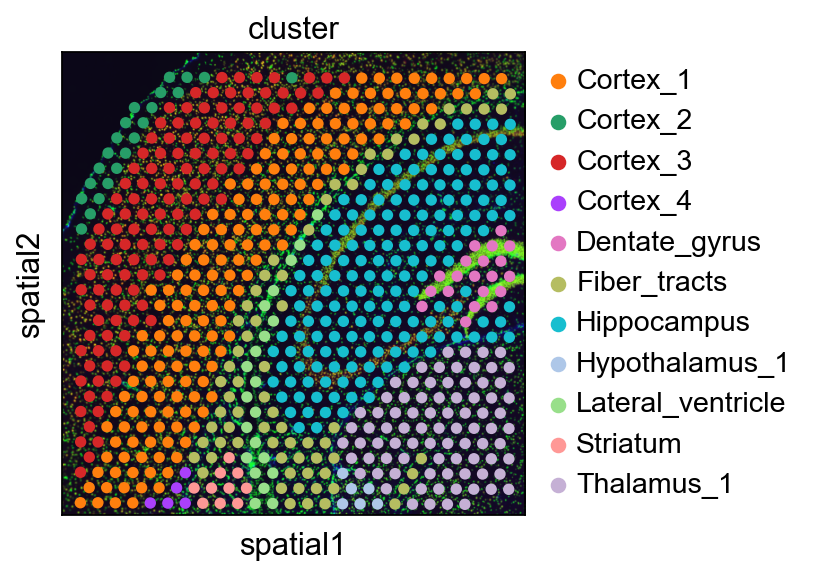

In [3]:
sq.pl.spatial_scatter(
    adata,
    library_key="library_id",
    color="cluster",
    wspace=0.3,
)

The fluorescence image provided with this dataset has three channels:
*DAPI* (specific to DNA), *anti-NEUN* (specific to neurons), *anti-GFAP*
(specific to Glial cells). We can directly visualize the channels with
the method `squidpy.im.ImageContainer.show`.


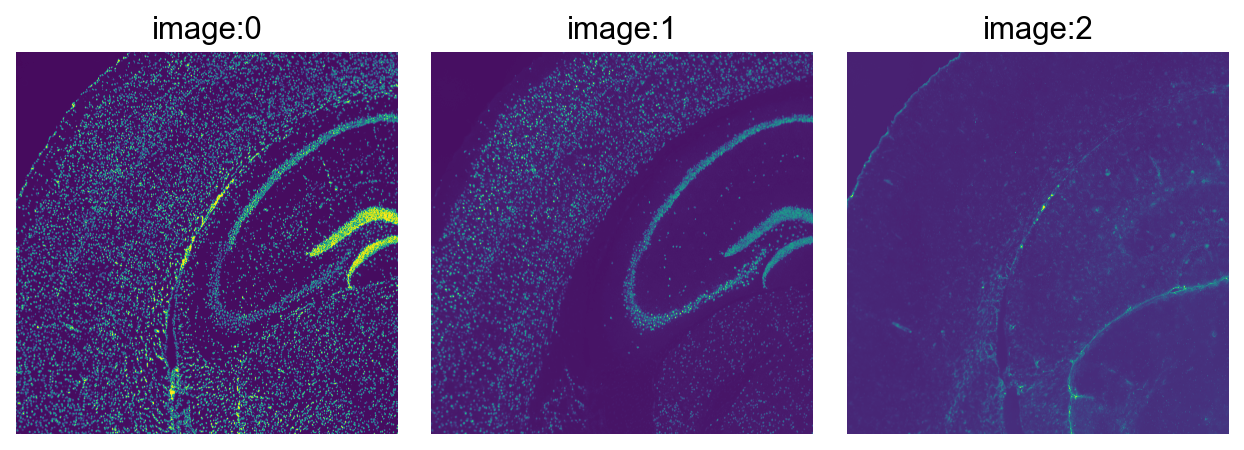

In [4]:
img.show(channelwise=True)

## Image segmentation

To calculate segmentation features, we first need to
segment the tissue image using `squidpy.im.segment`. But even before
that, it\'s best practice to pre-process the image by e.g. smoothing it
using in `squidpy.im.process`. We will then use the *DAPI* channel of
the fluorescence image (`channel_id = 0`).


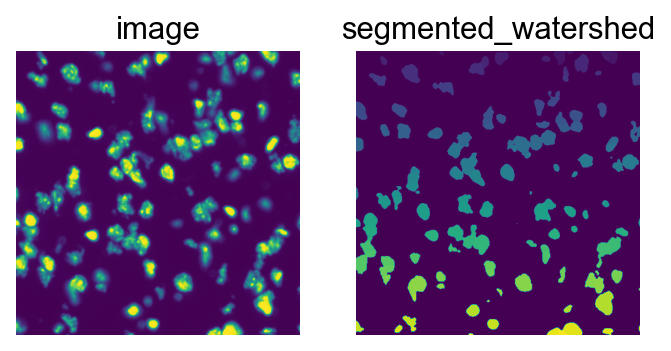

In [5]:
sq.im.process(
    img=img,
    layer="image",
    method="smooth",
)

sq.im.segment(img=img, layer="image_smooth", method="watershed", channel=0, chunks=1000)

# plot the resulting segmentation
fig, ax = plt.subplots(1, 2)
img_crop = img.crop_corner(2000, 2000, size=500)
img_crop.show(layer="image", channel=0, ax=ax[0])
img_crop.show(
    layer="segmented_watershed",
    channel=0,
    ax=ax[1],
)

The result of `squidpy.im.segment` is saved in
`img['segmented_watershed']` by default. It is a label image where each
segmented object is annotated with a different integer number.

## Segmentation features

We can now use the segmentation to calculate segmentation features.
These include morphological features of the segmented objects and
channel-wise image intensities beneath the segmentation mask. In
particular, we can count the segmented objects within each Visium spot
to get an approximation of the number of cells. In addition, we can
calculate the mean intensity of each fluorescence channel within the
segmented objects. Depending on the fluorescence channels, this can give
us e.g., an estimation of the cell type.


  0%|          | 0/704 [00:00<?, ?/s]

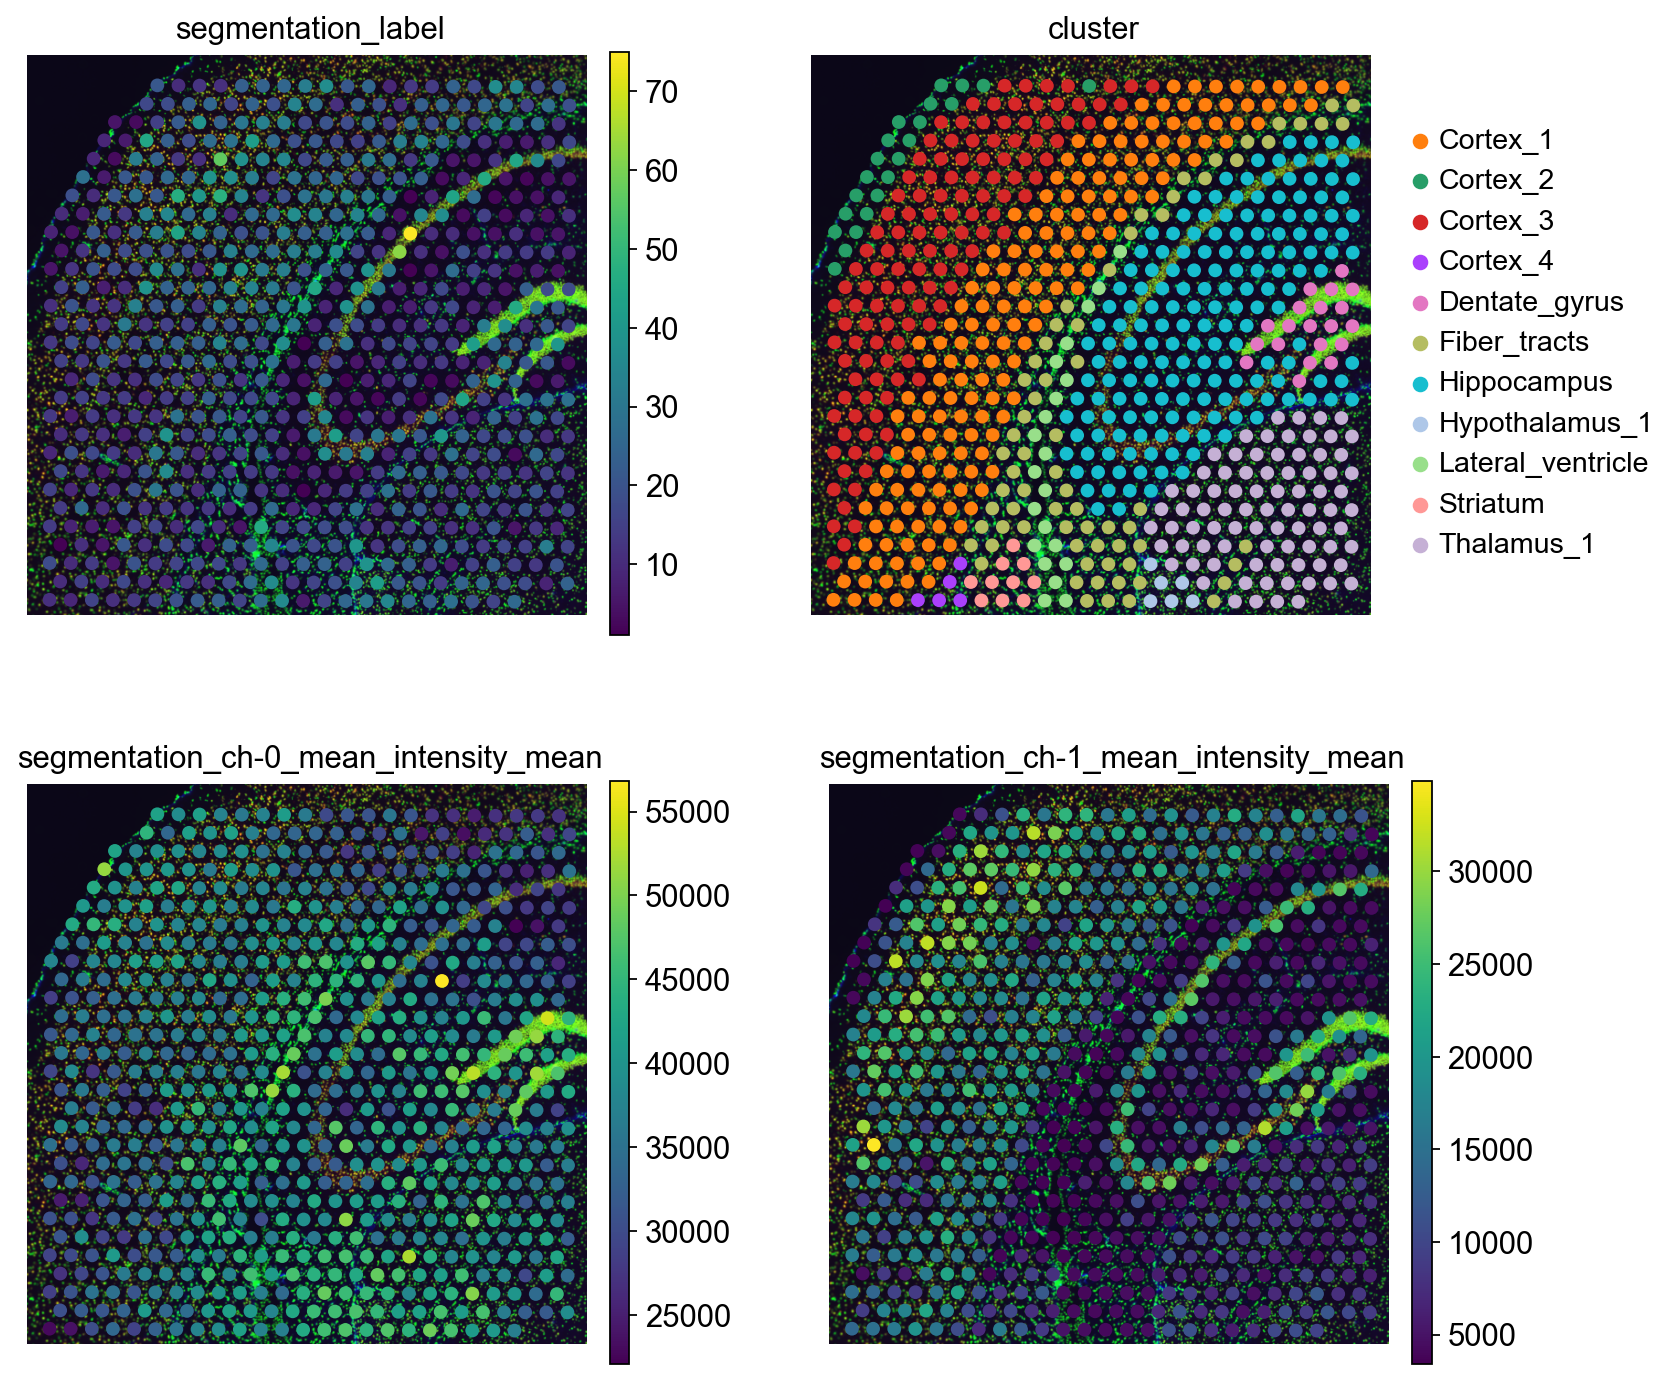

In [6]:
# define image layer to use for segmentation
features_kwargs = {"segmentation": {"label_layer": "segmented_watershed"}}
# calculate segmentation features
sq.im.calculate_image_features(
    adata,
    img,
    features="segmentation",
    layer="image",
    key_added="features_segmentation",
    n_jobs=1,
    features_kwargs=features_kwargs,
)
# plot results and compare with gene-space clustering
sc.pl.spatial(
    sq.pl.extract(adata, "features_segmentation"),
    color=[
        "segmentation_label",
        "cluster",
        "segmentation_ch-0_mean_intensity_mean",
        "segmentation_ch-1_mean_intensity_mean",
    ],
    frameon=False,
    ncols=2,
)

Above, we made use of `squidpy.pl.extract`, a method to extract all
features in a given `adata.obsm['{key}']` and
temporarily save them to `anndata.AnnData.obs`. Such method is
particularly useful for plotting purpose, as shown above.

The number of cells per Visium spot provides an interesting view of the
data that can enhance the characterization of gene-space clusters. We
can see that the cell-rich pyramidal layer of the Hippocampus has more
cells than the surrounding areas (upper left). This fine-grained view of
the Hippocampus is not visible in the gene clusters where the
Hippocampus is one cluster only.

The per-channel intensities plotted in the second row show us that the
areas labeled with *Cortex\_1* and *Cortex\_3* have a higher intensity
of channel 1, *anti-NEUN* (lower left). This means that these areas have
more neurons that the remaining areas in this crop. In addition, cluster
*Fiber\_tracts* and *lateral ventricles* seems to be enriched with
*Glial cells*, seen by the larger mean intensities of channel 2,
*anti-GFAP*, in these areas (lower right).

# Extract and cluster features

Using the function `squidpy.im.calculate_image_features` you can calculate image
features for each Visium spot and create a `obs x features` matrix in
`adata` that can then be analyzed together with the `obs x gene` gene
expression matrix.

Here, we will calculate summary, histogram, and texture features which are pre-implemented in Squidpy. 
Using a custom function to extract features from patches is also possible. For more information see the examples in [this tutorial](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_mibitof.html).


In [7]:
# define different feature calculation combinations
params = {
    # all features, corresponding only to tissue underneath spot
    "features_orig": {
        "features": ["summary", "texture", "histogram"],
        "scale": 1.0,
        "mask_circle": True,
    },
    # summary and histogram features with a bit more context, original resolution
    "features_context": {"features": ["summary", "histogram"], "scale": 1.0},
    # summary and histogram features with more context and at lower resolution
    "features_lowres": {"features": ["summary", "histogram"], "scale": 0.25},
}

for feature_name, cur_params in params.items():
    # features will be saved in `adata.obsm[feature_name]`
    sq.im.calculate_image_features(adata, img, layer="image", key_added=feature_name, n_jobs=1, **cur_params)

# combine features in one dataframe
adata.obsm["features"] = pd.concat([adata.obsm[f] for f in params.keys()], axis="columns")

# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

  0%|          | 0/704 [00:00<?, ?/s]

  0%|          | 0/704 [00:00<?, ?/s]

  0%|          | 0/704 [00:00<?, ?/s]

We can use the extracted image features to compute a new cluster
annotation. This could be useful to gain insights in similarities across
spots based on image morphology.

For this, we first define a helper function to cluster features.


In [8]:
def cluster_features(features: pd.DataFrame, like=None):
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]

Then, we calculate feature clusters using different features and compare
them to gene clusters:


/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_84186/1102943926.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(features)
/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_84186/1102943926.py:11: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(features)
/var/folders/s9/0d6yy20d44v60qd0nfkjlqdd541mvv/T/ipykernel_84186/1102943926.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnD

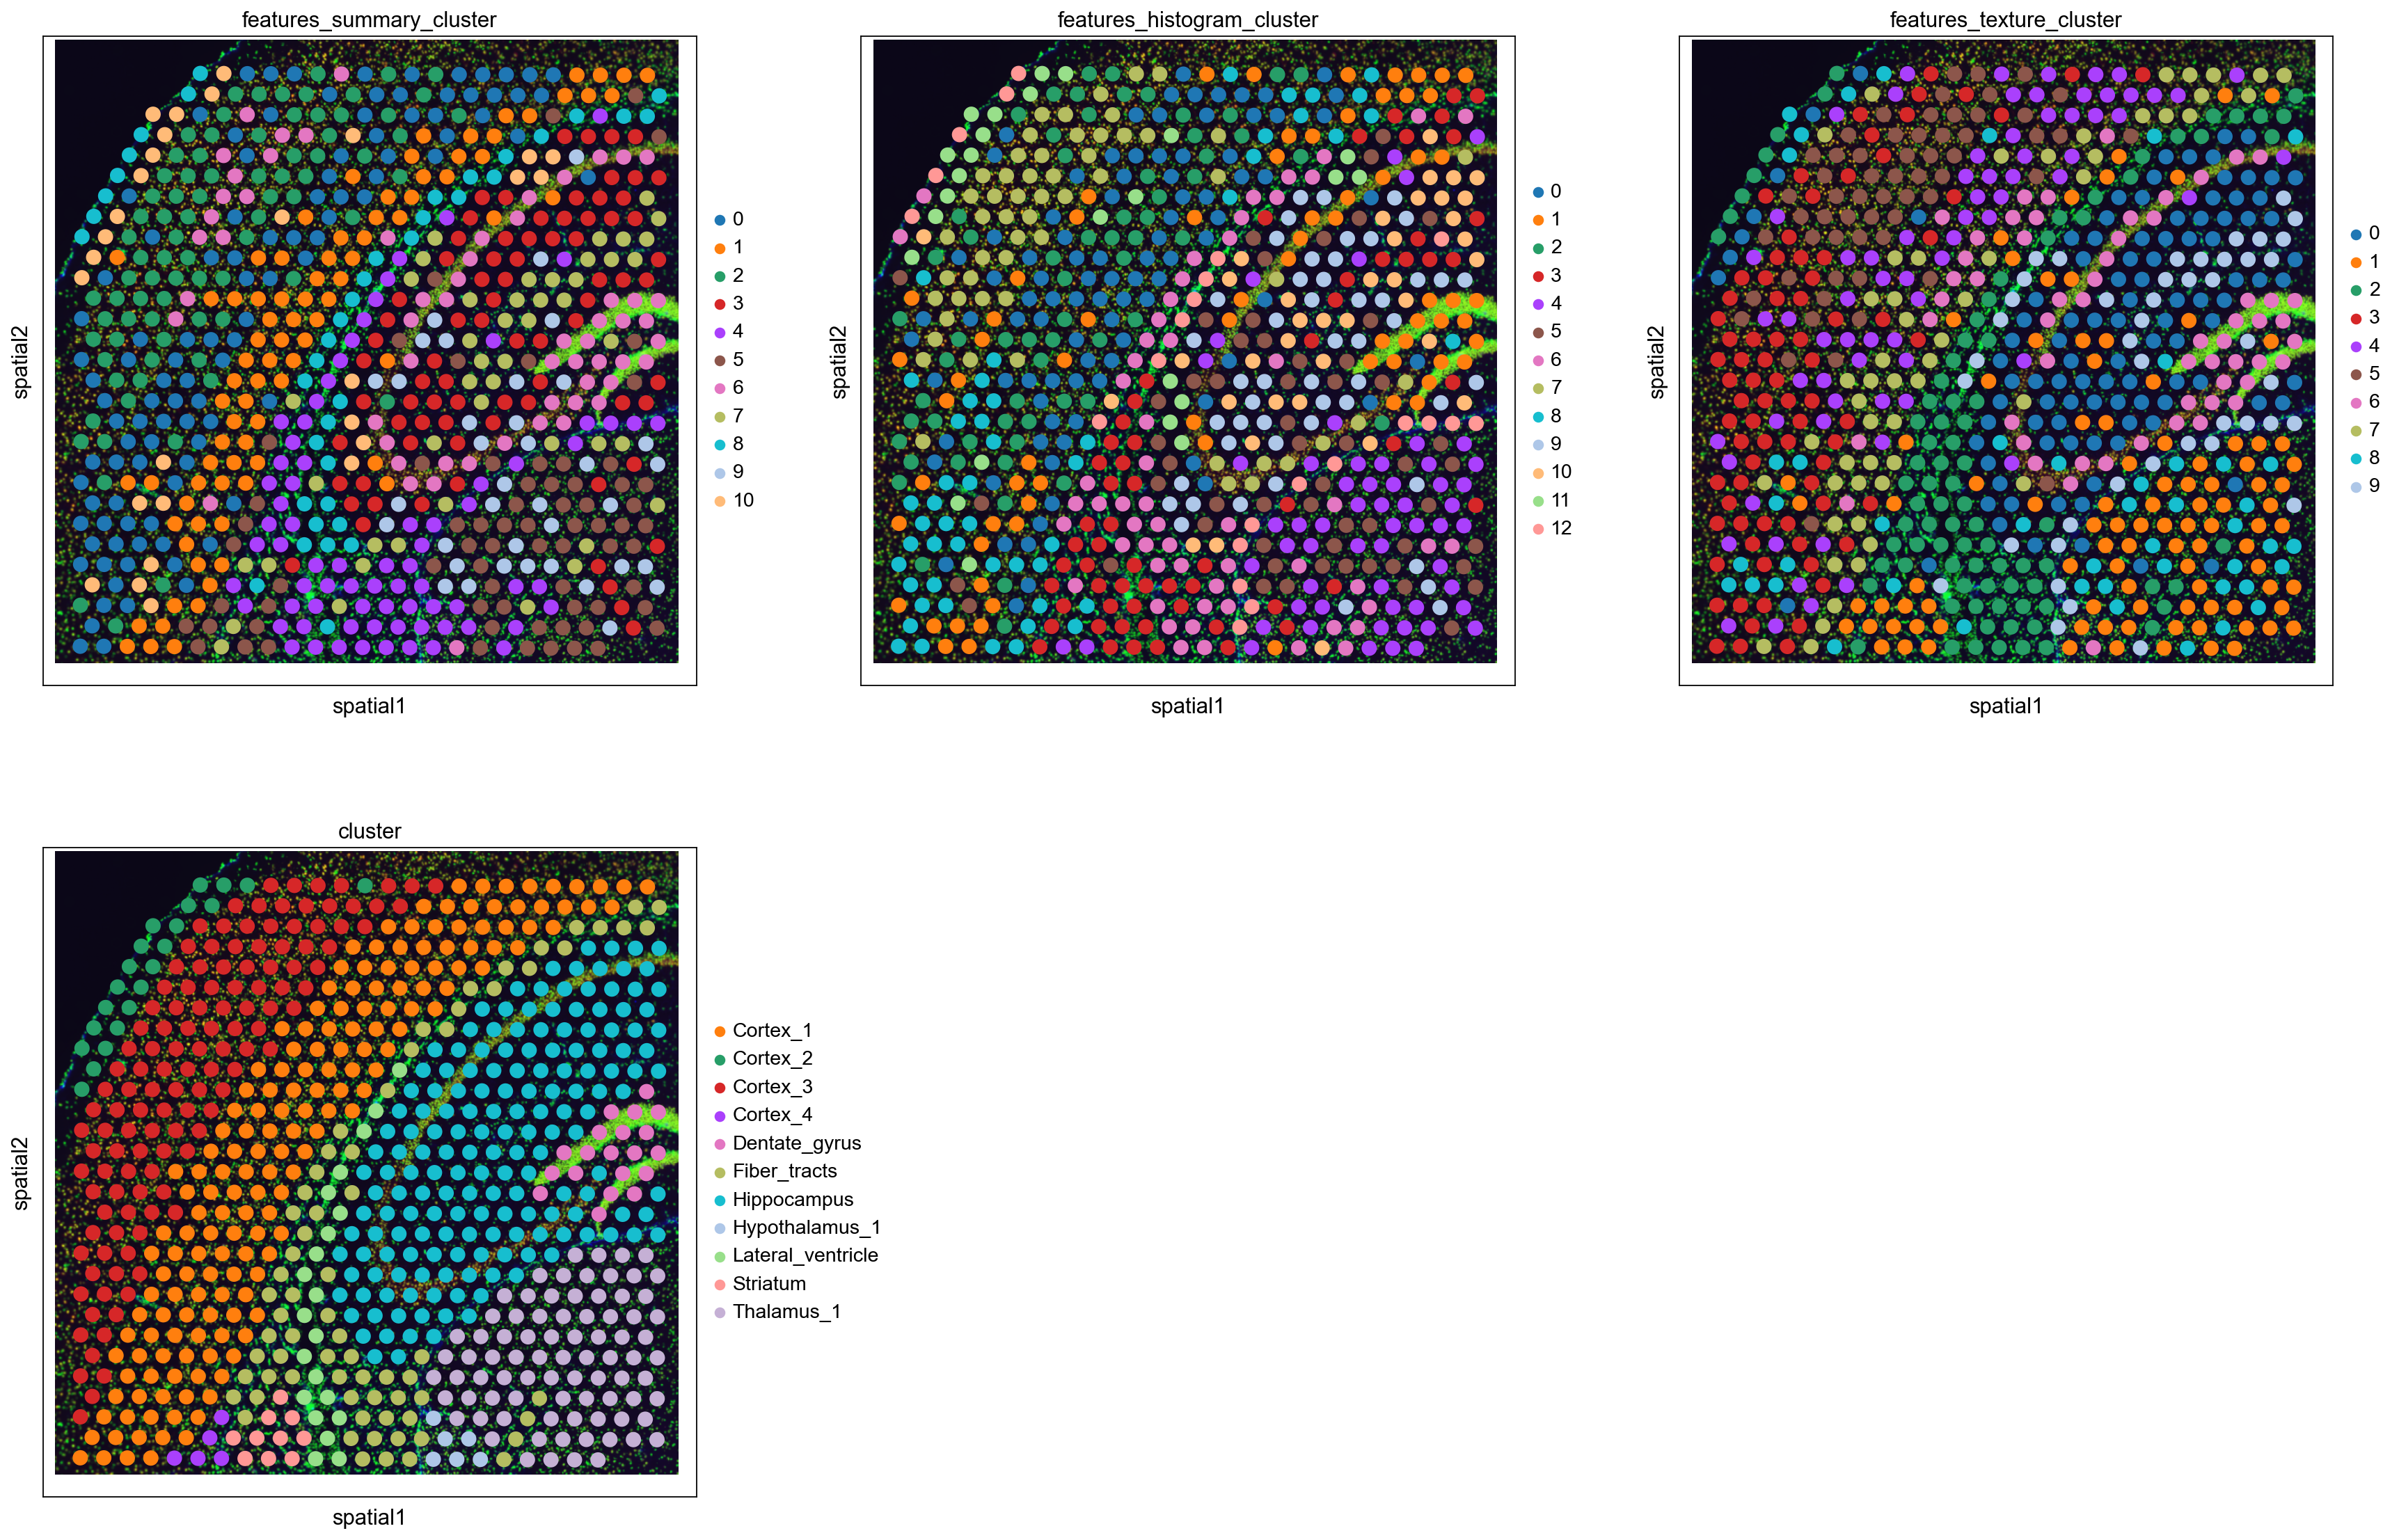

In [9]:
adata.obs["features_summary_cluster"] = cluster_features(adata.obsm["features"], like="summary")
adata.obs["features_histogram_cluster"] = cluster_features(adata.obsm["features"], like="histogram")
adata.obs["features_texture_cluster"] = cluster_features(adata.obsm["features"], like="texture")

sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(
    adata,
    color=[
        "features_summary_cluster",
        "features_histogram_cluster",
        "features_texture_cluster",
        "cluster",
    ],
    ncols=3,
)

Like the gene-space clusters (bottom middle), the feature space clusters
are also spatially coherent.

The feature clusters of the different feature extractors are quite
diverse, but all of them reflect the structure of the Hippocampus by
assigning different clusters to the different structural areas. This is
a higher level of detail than the gene-space clustering provides with
only one cluster for the Hippocampus.

The feature clusters also show the layered structure of the cortex, but
again subdividing it in more clusters than the gene-space clustering. It
might be possible to re-cluster the gene expression counts with a higher
resolution to also get more fine-grained clusters, but nevertheless the
image features seem to provide additional supporting information to the
gene-space clusters.
